In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, report_fit
from time import time
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Parameter Computation Class

In [2]:
class ParameterComputation:
    """This class computes the parameters for the epidemiological model."""

    def __init__(self, filepath='./epidemiological_model_data.csv', population=19_453_734, compartment_names=None,
                 data_split_min=None, data_split_max=None, constrained_beta=True):
        """This method initializes the parameters.

        :parameter filepath: String - Filepath of the epidemiological model data.
        :parameter population: Integer - Population of the epidemic region.
        :parameter compartment_names: Array - Array of strings specifying the compartments in the epidemiological model.
        :parameter data_split: Integer - Integer specifying the time period of days in which we will split the data.
        :parameter constrained_beta - Boolean specifying whether the exposure rate beta is unconstrained."""

        self.epidemiological_data = pd.read_csv(filepath)
        self.population = population
        self.parameters = self.parameter_initialization(constrained_beta)

        self.compartment_names = compartment_names

        self.epidemiological_data = self.epidemiological_data.iloc[data_split_min:data_split_max]

        self.epidemiological_compartment_values = self.epidemiological_data[self.compartment_names].values
        self.t = np.linspace(0, self.epidemiological_data.shape[0] - 1, self.epidemiological_data.shape[0])

        # Initial values of population dynamics.
        self.y0 = [self.epidemiological_data[f'{self.compartment_names[i]}'].iloc[0]
                   for i in range(len(self.compartment_names))]
        
        self.original_residual = None
        
        self.counter = 1

    @staticmethod
    def parameter_initialization(constrained_beta=True):
        """This method initializes the parameter values for the epidemiological model.

        :return parameters: Parameters for the epidemiological model."""

        # Set parameters including bounds
        parameters = Parameters()
#         pars.add('constraint_param', value=1, min=0, max=1, vary=True)
        
        # Exposure rate.
        if constrained_beta:
            parameters.add('beta', value=3, min=0.0, max=10)
        else:
            parameters.add('beta', value=3, min=1.5, max=5)

        # Population mixing coefficient.
        parameters.add('alpha', value=0.85 , min=0.7, max=1)

        # Infection rates for exposed individuals.
        parameters.add('zeta_uv', value=0.02, min=0, max=0.05)
#         parameters.add('zeta_fv', value=0.014, min=0, max=0.015)
        parameters.add('zeta_fv', value=0.003, min=0, max=0.007)
        parameters.add('zeta_bv', value=0.0003, min=0, max=0.007)

        # Hospitalization rates for infected individuals.
        parameters.add('delta_uv', value=0.00216666, min=0.0, max=0.00444444)
#         parameters.add('delta_fv', value=0.00116666, min=0.0, max=0.00444444)
        parameters.add('delta_fv', value=0.000516666, min=0.0, max=0.00444444)
        parameters.add('delta_bv', value=0.000516666, min=0.0, max=0.00444444)

        # Recovery rates for infected individuals.
        parameters.add('gamma_i_uv', value=0.05, min=0.040, max=0.055)
#         parameters.add('gamma_i_bv', value=0.05, min=0.0425, max=0.055)
        parameters.add('gamma_i_fv', value=0.053, min=0.045, max=0.055)
        parameters.add('gamma_i_bv', value=0.053, min=0.0475, max=0.065)

        # Recovery rates for hospitalized individuals.
        parameters.add('gamma_h_uv', value=0.0277777, min=0.025, max=0.055)
#         parameters.add('gamma_h_bv', value=0.0277777, min=0.025, max=0.055)
        parameters.add('gamma_h_fv', value=0.0377777, min=0.03, max=0.055)
        parameters.add('gamma_h_bv', value=0.0377777, min=0.03, max=0.065)

        # Death rates for infected individuals.
        parameters.add('mu_i_uv', value=0.00155555555, min=0.00005555555, max=0.0033333333)
#         parameters.add('mu_i_bv', value=0.00045555555, min=0.00005555555, max=0.0033333333)
        parameters.add('mu_i_fv', value=0.000005555555, min=0.000005555555, max=0.0033333333)
        parameters.add('mu_i_bv', value=0.000005555555, min=0.000002555555, max=0.0033333333)

        # Death rates for hospitalized individuals.
        parameters.add('mu_h_uv', value=0.00877777 , min=0.00277777, max=0.01388888)
#         parameters.add('mu_h_bv', value=0.00477777 , min=0.00277777, max=0.01388888)
        parameters.add('mu_h_fv', value=0.00277777 , min=0.00077777, max=0.01388888)
        parameters.add('mu_h_bv', value=0.00087777 , min=0.000177777, max=0.01388888)

        # Rate at which previously exposed individuals become susceptible again.
        parameters.add('exp_to_suv', value=0.25 , min=0.0, max=1)
#         parameters.add('exp_to_spv', value=0.4 , min=0.0, max=1)
        parameters.add('exp_to_sfv', value=0.5 , min=0.0, max=1)
        parameters.add('exp_to_sbv', value=0.5 , min=0.0, max=1)
        
        # Parameters to allow recovered individuals to get reinfected
#         parameters.add('beta_r', value=3, min=-np.inf, max=np.inf)
        parameters.add('zeta_ruv', value=0.007, min=0, max=0.05)
#         parameters.add('zeta_rfv', value=0.007, min=0, max=0.014)
        parameters.add('zeta_rfv', value=0.004, min=0, max=0.007)
        parameters.add('zeta_rbv', value=0.004, min=0, max=0.007)
    
        parameters.add('exp_to_ruv', value=0.25 , min=0.0, max=1)
#         parameters.add('exp_to_rpv', value=0.4 , min=0.0, max=1)
        parameters.add('exp_to_rfv', value=0.5 , min=0.0, max=1)
        parameters.add('exp_to_rbv', value=0.5 , min=0.0, max=1)
        
        return parameters

    # noinspection DuplicatedCode
    def differential_equations(self, y, t, population, parameters, call_signature_ode_int=True,
                               differential_equations_version=1):
        """This method models the differential equations for the epidemiological model.

        :param y: Vector of sub-compartment population dynamics
        :param t: Time span of simulation
        :param population: Total Population
        :param parameters: Parameter values
        :param call_signature_ode_int: Boolean - Indicates if the calling signature of the differential_equations method
                                                 is that of scipy's odeint method.
        :param differential_equations_version: Integer: Version of differential equations/model to be used.

        :returns derivatives of the model compartments."""

        if not call_signature_ode_int:
            t, y = y, t
        
        # VERSION 1:
        if differential_equations_version == 1:
            """SEIQRD Model with standard incidence that doesn't correct for deaths and hospitalizations.
               We don't allow recovered individuals to be susceptible again. Model accounts for vaccination rates.
               We model susceptible, exposed, and recovered people to be vaccinated. Exposure rate is 
               dependent on the number of new cases."""

            # Sub-compartments
            s_uv, s_fv, s_bv, e_uv, e_fv, e_bv, i_uv, i_fv, i_bv, \
                h_uv, h_fv, h_bv, r_uv, r_fv, r_bv, d_uv, d_fv, d_bv = y
            
            # Force of infection
            total_infections = max((i_uv + i_fv + i_bv), 1)

            # Parameter Values
            beta_s = parameters['beta_s'].value
            alpha = parameters['alpha'].value

            zeta_uv = parameters['zeta_uv'].value
            zeta_fv = parameters['zeta_bv'].value
            zeta_bv = parameters['zeta_bv'].value

            delta_uv = parameters['delta_uv'].value
            delta_fv = parameters['delta_bv'].value
            delta_bv = parameters['delta_bv'].value

            mu_i_uv = parameters['mu_i_uv'].value
            mu_i_bv = parameters['mu_i_bv'].value
            mu_i_bv = parameters['mu_i_bv'].value

            mu_h_uv = parameters['mu_h_uv'].value
            mu_h_bv = parameters['mu_h_bv'].value
            mu_h_bv = parameters['mu_h_bv'].value

            gamma_i_uv = parameters['gamma_i_uv'].value
            gamma_i_bv = parameters['gamma_i_bv'].value
            gamma_i_bv = parameters['gamma_i_bv'].value

            gamma_h_uv = parameters['gamma_h_uv'].value
            gamma_h_bv = parameters['gamma_h_bv'].value
            gamma_h_bv = parameters['gamma_h_bv'].value

            exp_to_s_uv = parameters['exp_to_suv'].value
            exp_to_s_bv = parameters['exp_to_spv'].value
            exp_to_s_bv = parameters['exp_to_sfv'].value

            # Ordinary Differential Equations.
#             beta = beta_s * self.epidemiological_data['New Cases'].iloc[min(int(t), len(self.epidemiological_data) - 1)]
            beta = beta_s
            
            # Susceptible
            ds_uv_dt = -beta * s_uv * (total_infections ** alpha) / population + exp_to_s_uv * e_uv - \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_uv
            ds_fv_dt = -beta * s_fv * (total_infections ** alpha) / population + exp_to_s_bv * e_fv + \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_uv - self.epidemiological_data[
                           'percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_fv
            ds_bv_dt = -beta * s_bv * (total_infections ** alpha) / population + exp_to_s_bv * e_bv + \
                       self.epidemiological_data['percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_fv

            # Exposed
            de_uv_dt = beta * s_uv * (total_infections ** alpha) / population - zeta_uv * e_uv - exp_to_s_uv * e_uv - \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_uv
            de_fv_dt = beta * s_fv * (total_infections ** alpha) / population - zeta_fv * e_fv - exp_to_s_bv * e_fv + \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_uv - self.epidemiological_data[
                           'percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_fv
            de_bv_dt = beta * s_bv * (total_infections ** alpha) / population - zeta_bv * e_bv - exp_to_s_bv * e_bv + \
                self.epidemiological_data['percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_fv

            # Infected
            di_uv_dt = zeta_uv * e_uv - delta_uv * i_uv - gamma_i_uv * i_uv - mu_i_uv * i_uv
            di_fv_dt = zeta_fv * e_fv - delta_fv * i_fv - gamma_i_bv * i_fv - mu_i_bv * i_fv
            di_bv_dt = zeta_bv * e_bv - delta_bv * i_bv - gamma_i_bv * i_bv - mu_i_bv * i_bv
            
            # Hospitalized
            dh_uv_dt = delta_uv * i_uv - gamma_h_uv * h_uv - mu_h_uv * h_uv
            dh_fv_dt = delta_fv * i_fv - gamma_h_bv * h_fv - mu_h_bv * h_fv
            dh_bv_dt = delta_bv * i_bv - gamma_h_bv * h_bv - mu_h_bv * h_bv

            # Recovered
            dr_uv_dt = gamma_i_uv * i_uv + gamma_h_uv * h_uv - \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_uv
            dr_fv_dt = gamma_i_bv * i_fv + gamma_h_bv * h_fv + \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_uv - self.epidemiological_data[
                           'percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_fv
            dr_bv_dt = gamma_i_bv * i_bv + gamma_h_bv * h_bv + \
                self.epidemiological_data['percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_fv
            
#             dr_uv_dt = gamma_i_uv * i_uv + gamma_h_uv * h_uv 
#             dr_fv_dt = gamma_i_bv * i_fv + gamma_h_bv * h_fv
#             dr_bv_dt = gamma_i_bv * i_bv + gamma_h_bv * h_bv 

            # Deceased
            dd_uv_dt = mu_i_uv * i_uv + mu_h_uv * h_uv
            dd_fv_dt = mu_i_bv * i_fv + mu_h_bv * h_fv
            dd_bv_dt = mu_i_bv * i_bv + mu_h_bv * h_bv

            return ds_uv_dt, ds_fv_dt, ds_bv_dt, de_uv_dt, de_fv_dt, de_bv_dt, di_uv_dt, di_fv_dt, di_bv_dt, \
                dh_uv_dt, dh_fv_dt, dh_bv_dt, dr_uv_dt, dr_fv_dt, dr_bv_dt, dd_uv_dt, dd_fv_dt, dd_bv_dt
        
        elif differential_equations_version == 2:
            """SEIQRD Model with standard incidence that doesn't correct for deaths and hospitalizations.
               We don't allow recovered individuals to be susceptible again. Model accounts for vaccination rates.
               We model susceptible, exposed, and recovered people to be vaccinated. Exposure rate is 
               dependent on the number of new cases."""
            
            # Sub-compartments
            s_uv, s_fv, s_bv, e_uv, e_fv, e_bv, i_uv, i_fv, i_bv, \
                h_uv, h_fv, h_bv, r_uv, r_fv, r_bv, d_uv, d_fv, d_bv = y
            
            # Force of infection
            total_infections = max((i_uv + i_fv + i_bv), 1)

            # Parameter Values
            beta = parameters['beta'].value
            alpha = parameters['alpha'].value

            zeta_uv = parameters['zeta_uv'].value
            zeta_fv = parameters['zeta_fv'].value
            zeta_bv = parameters['zeta_bv'].value
            zeta_ruv = parameters['zeta_ruv'].value
            zeta_rfv = parameters['zeta_rfv'].value
            zeta_rbv = parameters['zeta_rbv'].value

            delta_uv = parameters['delta_uv'].value
            delta_fv = parameters['delta_fv'].value
            delta_bv = parameters['delta_bv'].value

            mu_i_uv = parameters['mu_i_uv'].value
            mu_i_fv = parameters['mu_i_fv'].value
            mu_i_bv = parameters['mu_i_bv'].value

            mu_h_uv = parameters['mu_h_uv'].value
            mu_h_fv = parameters['mu_h_fv'].value
            mu_h_bv = parameters['mu_h_bv'].value

            gamma_i_uv = parameters['gamma_i_uv'].value
            gamma_i_fv = parameters['gamma_i_fv'].value
            gamma_i_bv = parameters['gamma_i_bv'].value

            gamma_h_uv = parameters['gamma_h_uv'].value
            gamma_h_fv = parameters['gamma_h_fv'].value
            gamma_h_bv = parameters['gamma_h_bv'].value

            exp_to_s_uv = parameters['exp_to_suv'].value
            exp_to_s_fv = parameters['exp_to_sfv'].value
            exp_to_s_bv = parameters['exp_to_sbv'].value
            exp_to_r_uv = parameters['exp_to_ruv'].value
            exp_to_r_fv = parameters['exp_to_rfv'].value
            exp_to_r_bv = parameters['exp_to_rbv'].value

            # Ordinary Differential Equations.
#             beta = beta_s * self.epidemiological_data['New Cases'].iloc[min(int(t), len(self.epidemiological_data) - 1)]
#             beta = beta_s
            
            # Susceptible
            ds_uv_dt = -beta * s_uv * (total_infections ** alpha) / population + exp_to_s_uv * e_uv - \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_uv
            ds_fv_dt = -beta * s_fv * (total_infections ** alpha) / population + exp_to_s_fv * e_fv + \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_uv - self.epidemiological_data[
                           'percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_fv
            ds_bv_dt = -beta * s_bv * (total_infections ** alpha) / population + exp_to_s_bv * e_bv + \
                       self.epidemiological_data['percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * s_fv

            # Exposed
            de_uv_dt = beta * s_uv * (total_infections ** alpha) / population + beta * r_uv * (total_infections ** alpha) / population - zeta_uv * e_uv - zeta_ruv * e_uv - exp_to_s_uv * e_uv - exp_to_r_uv * e_uv - \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_uv
            de_fv_dt = beta * s_fv * (total_infections ** alpha) / population + beta * r_fv * (total_infections ** alpha) / population - zeta_fv * e_fv - zeta_rfv * e_fv - exp_to_s_fv * e_fv - exp_to_r_fv * e_fv + \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_uv - self.epidemiological_data[
                           'percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_fv
            de_bv_dt = beta * s_bv * (total_infections ** alpha) / population + beta * r_bv * (total_infections ** alpha) / population - zeta_bv * e_bv - zeta_rbv * e_bv - exp_to_s_bv * e_bv - exp_to_r_bv * e_bv + \
                self.epidemiological_data['percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * e_fv

            # Infected
            di_uv_dt = zeta_uv * e_uv + zeta_ruv * e_uv - delta_uv * i_uv - gamma_i_uv * i_uv - mu_i_uv * i_uv
            di_fv_dt = zeta_fv * e_fv + zeta_rfv * e_fv - delta_fv * i_fv - gamma_i_fv * i_fv - mu_i_fv * i_fv
            di_bv_dt = zeta_bv * e_bv + zeta_rbv * e_bv - delta_bv * i_bv - gamma_i_bv * i_bv - mu_i_bv * i_bv
            
            # Hospitalized
            dh_uv_dt = delta_uv * i_uv - gamma_h_uv * h_uv - mu_h_uv * h_uv
            dh_fv_dt = delta_fv * i_fv - gamma_h_fv * h_fv - mu_h_fv * h_fv
            dh_bv_dt = delta_bv * i_bv - gamma_h_bv * h_bv - mu_h_bv * h_bv

            # Recovered
            dr_uv_dt = gamma_i_uv * i_uv + gamma_h_uv * h_uv - beta * r_uv * (total_infections ** alpha) / population + exp_to_r_uv * e_uv -  \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_uv
            dr_fv_dt = gamma_i_fv * i_fv + gamma_h_fv * h_fv - beta * r_fv * (total_infections ** alpha) / population + exp_to_r_fv * e_fv + \
                self.epidemiological_data['percentage_unvaccinated_to_fully_vaccinated'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_uv - self.epidemiological_data[
                           'percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_fv
            dr_bv_dt = gamma_i_bv * i_bv + gamma_h_bv * h_bv - beta * r_bv * (total_infections ** alpha) / population + exp_to_r_bv * e_bv + \
                self.epidemiological_data['percentage_fully_vaccinated_to_boosted'].iloc[
                           min(int(t), len(self.epidemiological_data) - 1)] * r_fv
            
#             dr_uv_dt = gamma_i_uv * i_uv + gamma_h_uv * h_uv 
#             dr_fv_dt = gamma_i_bv * i_fv + gamma_h_bv * h_fv
#             dr_bv_dt = gamma_i_bv * i_bv + gamma_h_bv * h_bv 

            # Deceased
            dd_uv_dt = mu_i_uv * i_uv + mu_h_uv * h_uv
            dd_fv_dt = mu_i_fv * i_fv + mu_h_fv * h_fv
            dd_bv_dt = mu_i_bv * i_bv + mu_h_bv * h_bv

            return ds_uv_dt, ds_fv_dt, ds_bv_dt, de_uv_dt, de_fv_dt, de_bv_dt, di_uv_dt, di_fv_dt, di_bv_dt, \
                dh_uv_dt, dh_fv_dt, dh_bv_dt, dr_uv_dt, dr_fv_dt, dr_bv_dt, dd_uv_dt, dd_fv_dt, dd_bv_dt
            
    def ode_solver(self, y0, t, population, parameters, solver='odeint', method='RK45',
                   differential_equations_version=1):
        """This function solves the ordinary differential equations for the epidemiological model.

        :parameter y0: Vector of initial population dynamics
        :parameter t: Time span of simulation
        :parameter population: Total Population
        :parameter parameters: Parameter values
        :parameter solver: String - Name of the solver
        :parameter method: Integration method used by the solver.
        :parameter differential_equations_version: Integer representing the model/differential equations we want to use.

        :return x_odeint: model predictions from Scipy's odeint method
        :return x_solve_ivp.y.T: model predictions form Scipy's solve_ivp method"""

        if solver == 'odeint':
            x_odeint = odeint(self.differential_equations, y0, t,
                              args=(population, parameters, True, differential_equations_version))
#             print(self.counter)
#             self.counter += 1
            return x_odeint

        elif solver == 'solve_ivp':
            x_solve_ivp = solve_ivp(self.differential_equations, y0=y0, t_span=(min(t), max(t)), t_eval=t,
                                    method=method, args=(population, parameters, False, differential_equations_version))
#             print(self.counter)
#             self.counter += 1
            return x_solve_ivp.y.T

    def residual(self, parameters, t, data, solver='odeint', method='RK45', differential_equations_version=1):
        """This function computes the residuals between the model predictions and the actual data.

        :parameter parameters: Parameter values
        :parameter t: Time span of simulation
        :parameter data: Real-world data we want to fit our model to
        :parameter solver: String - Name of the solver
        :parameter method: Integration method used by the solver.
        :parameter differential_equations_version: Integer representing the model/differential equations we want to use.

        :returns: residuals"""

        model_predictions = self.ode_solver(self.y0, t, self.population, parameters, solver=solver, method=method,
                                            differential_equations_version=differential_equations_version)

        model_predictions = pd.DataFrame(model_predictions, columns=self.compartment_names)
        
        # The original way in which residuals were computed. Takes the difference between predictions and data.
        residual_original = (model_predictions.values - data).ravel()
        self.original_residual = residual_original
        
        # Normalized residuals so all features contribute equally to the loss.
        max_array = np.maximum.reduce([model_predictions.values, data])
        residual = ((model_predictions.values - data) / max_array).ravel()
        
        return residual

    def residual_odeint(self, parameters, t, data, method='RK45', differential_equations_version=1):
        residual_odeint = self.residual(parameters, t, data, solver='odeint', method=method,
                                        differential_equations_version=differential_equations_version)
        return residual_odeint

    def residual_solve_ivp(self, parameters, t, data, method='RK45', differential_equations_version=1):
        residual_solve_ivp = self.residual(parameters, t, data, solver='solve_ivp', method=method,
                                           differential_equations_version=differential_equations_version)
        return residual_solve_ivp

    def plot(self, model_predictions):
        """This method plots the model predictions vs the actual data.

        :parameter model_predictions: Array - Model predictions."""

        for i, compartment_name in enumerate(self.compartment_names):
            plt.figure(figsize=(16, 10))
            plt.plot(self.t, self.epidemiological_compartment_values[:, i], linewidth=3, label=compartment_name)
            plt.plot(self.t, model_predictions[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
            plt.xlabel('Days', fontsize=24)
            plt.ylabel('Population', fontsize=24)
            plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.legend(fontsize=20)
            plt.show()

In [ ]:
# number_of_epidemiological_models = 4

# minimization_methods = ['leastsq', 'least_squares', 'differential_evolution', 'brute', 'basinhopping', 'ampgo',
#                         'nelder', 'lbfgsb', 'powell', 'cg', 'newton', 'cobyla', 'bfgs', 'tnc', 'trust-ncg',
#                         'trust-exact', 'trust-krylov', 'trust-constr', 'dogleg', 'slsqp', 'emcee', 'shgo',
#                         'dual_annealing']

# integration_methods = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']

# compartments = ['Susceptible_UV', 'Susceptible_PV', 'Susceptible_FV', 'Exposed_UV', 'Exposed_PV', 'Exposed_FV',
#                 'Infected_UV', 'Infected_PV', 'Infected_FV', 'Hospitalized_UV', 'Hospitalized_PV',
#                 'Hospitalized_FV', 'Recovered_UV', 'Recovered_PV', 'Recovered_FV', 'Dead_UV', 'Dead_PV', 'Dead_FV']

# parameter_computation = ParameterComputation(filepath='./epidemiological_model_data_proportional_split.csv', compartment_names=compartments, constrained_beta=True)

### Solver = ODEINT

Note: The ODE solver doesn't take a specific integration method as input. It's provided so that the same code can be used for Scipy.solve_ivp

In [ ]:
# # SOLVER = odeint
# for minimization_method in minimization_methods:
#     print(f'\n\n\nMinimization Method: {minimization_method}\n')
#     start = time()
#     model_fit_odeint = minimize(parameter_computation.residual_odeint, parameter_computation.parameters,
#                                 args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
#                                       'RK45', 1), method=minimization_method)
#     print('Runtime:', time() - start, 'seconds')
#     model_pred = parameter_computation.epidemiological_compartment_values + \
#         model_fit_odeint.residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
#     print('Model Fit:\n', report_fit(model_fit_odeint))
# #     parameter_computation.plot(model_pred)

### Solver = solve_ivp

In [ ]:
# # SOLVER = solve_ivp
# for minimization_method in minimization_methods:
#     for integration_method in integration_methods:
#         parameter_computation = ParameterComputation(filepath='./epidemiological_model_data_proportional_split.csv', compartment_names=compartments, constrained_beta=False)
        
#         print(f'\n\n\nMinimization Method: {minimization_method}\n Integration Method: {integration_method}\n')
#         start = time()
#         model_fit_solve_ivp = minimize(
#             parameter_computation.residual_solve_ivp, parameter_computation.parameters,
#             args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
#                   integration_method, 4), method=minimization_method)
#         print('Runtime:', time() - start, 'seconds')
#         model_pred = parameter_computation.epidemiological_compartment_values + \
#             model_fit_solve_ivp.residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
#         print('Model Fit:\n', report_fit(model_fit_solve_ivp))
# #         parameter_computation.plot(model_pred)

### RK23 Leastsq CDC Initialization Params

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 28
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'RK45', 2), method='leastsq', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### RK45 Leastsq CDC

Split 1 of 10:

Runtime: 3.370391368865967 seconds
Split Residual: 30479151.53528817
-------------------------------
Split 2 of 10:

Runtime: 3.090151309967041 seconds
Split Residual: 7037210.634689264
-------------------------------
Split 3 of 10:

Runtime: 2.583216428756714 seconds
Split Residual: 9901540.591534186
-------------------------------
Split 4 of 10:

Runtime: 23.14736008644104 seconds
Split Residual: 11802584.275505085
-------------------------------
Split 5 of 10:

Runtime: 2.731843948364258 seconds
Split Residual: 15128878.423915308
-------------------------------
Split 6 of 10:

Runtime: 7.079574108123779 seconds
Split Residual: 21504062.523007773
-------------------------------
Split 7 of 10:

Runtime: 7.593515872955322 seconds
Split Residual: 167042118.7096516
-------------------------------
Split 8 of 10:

Runtime: 8.453752756118774 seconds
Split Residual: 31598417.931151815
-------------------------------
Split 9 of 10:

Runtime: 4.9457433223724365 seconds
Split Re

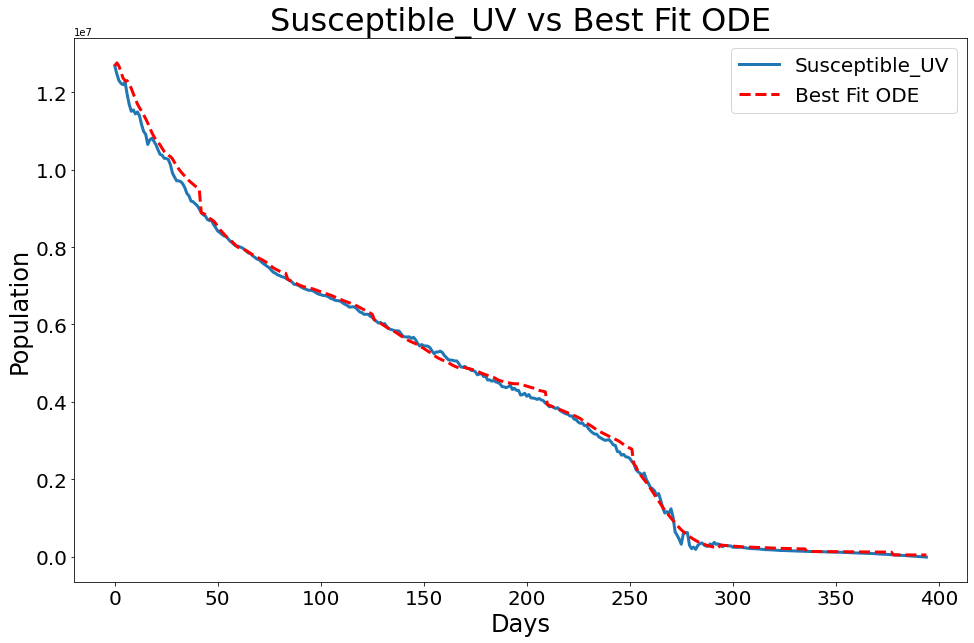

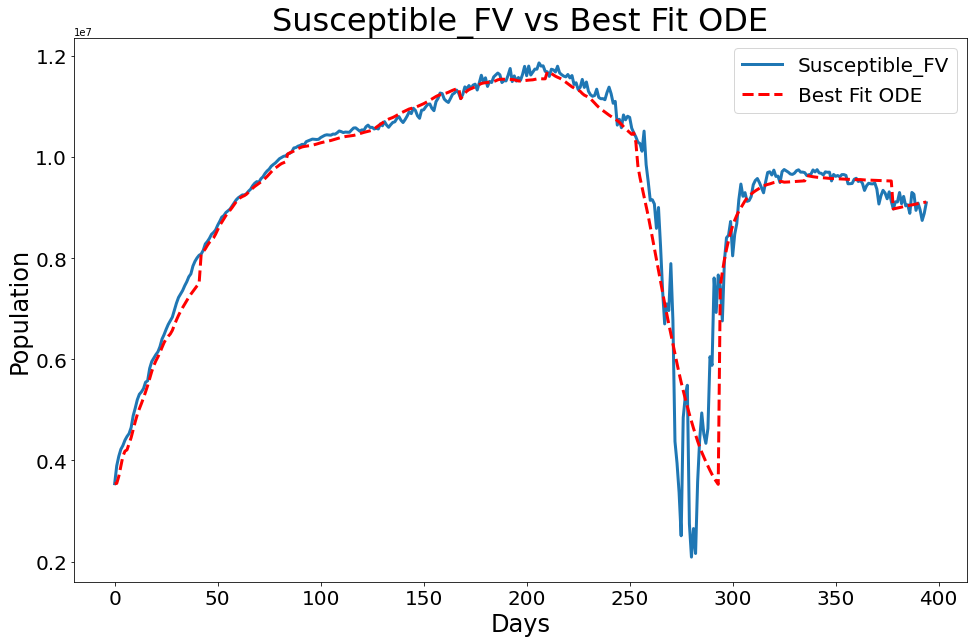

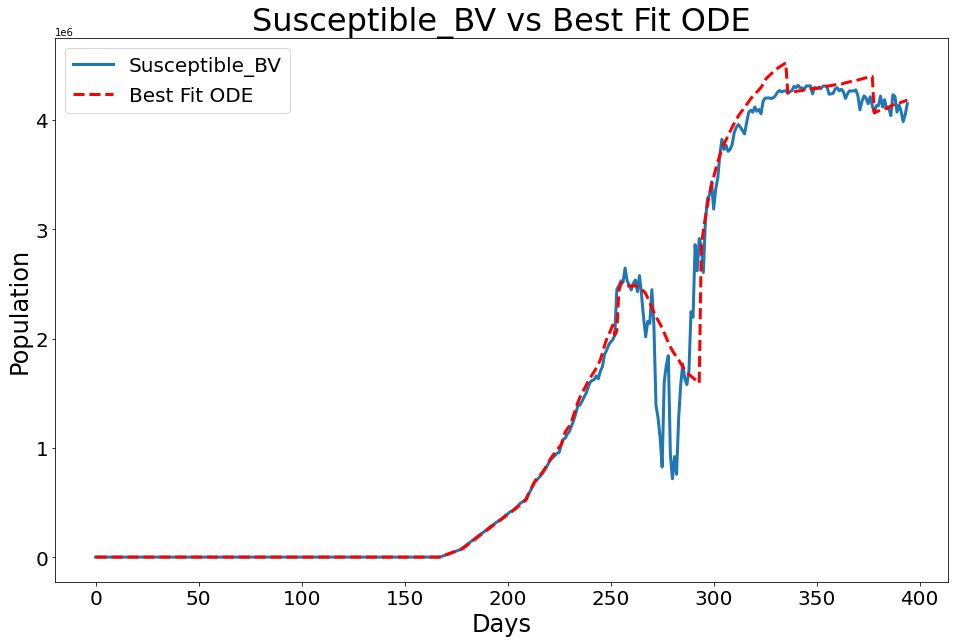

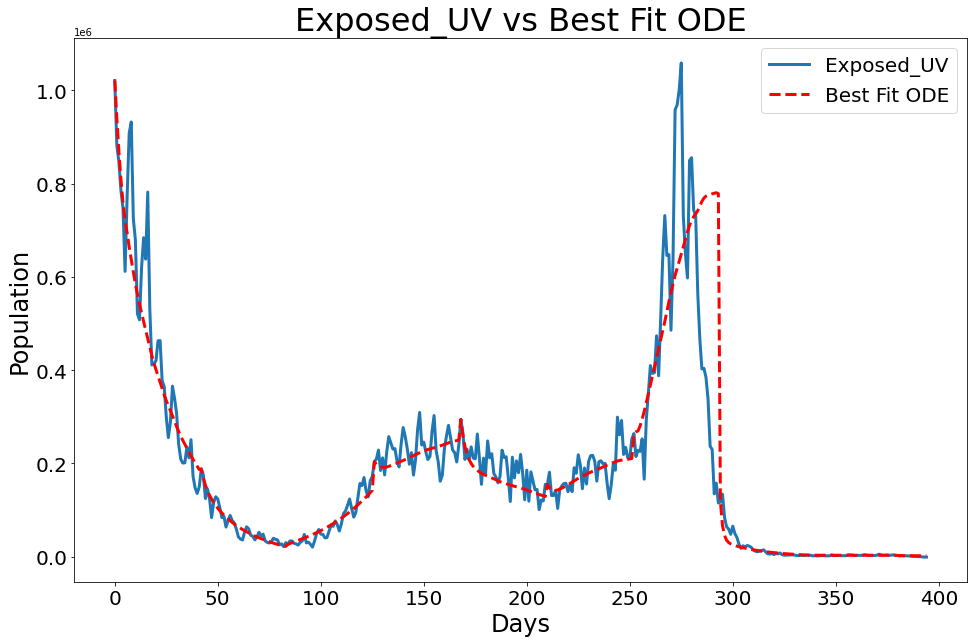

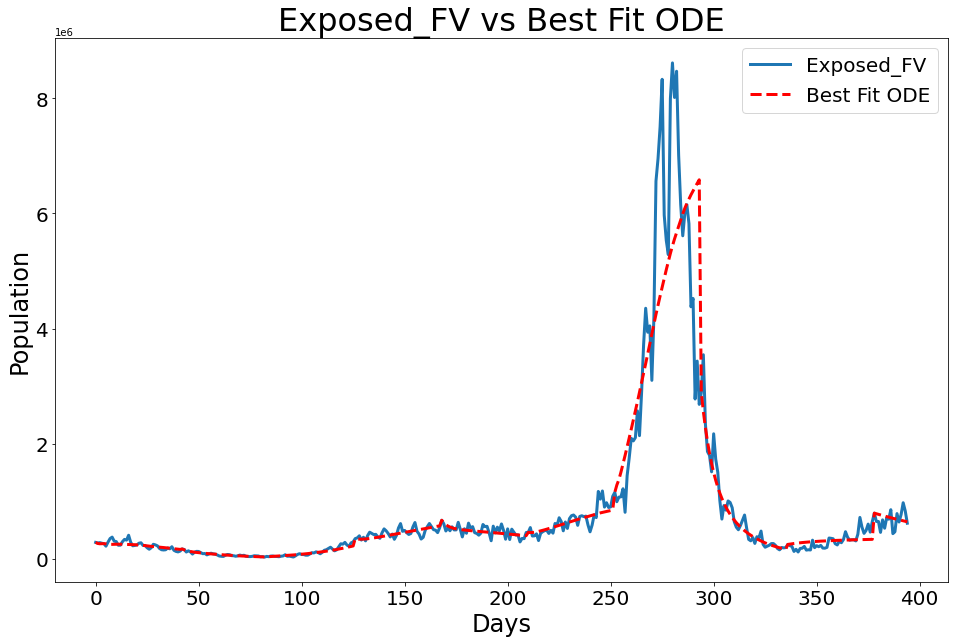

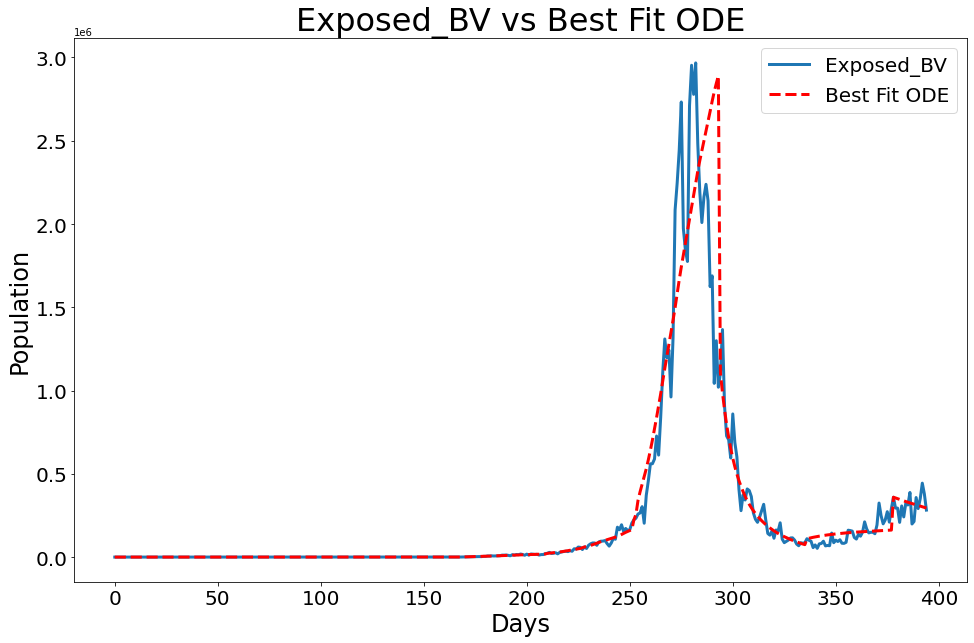

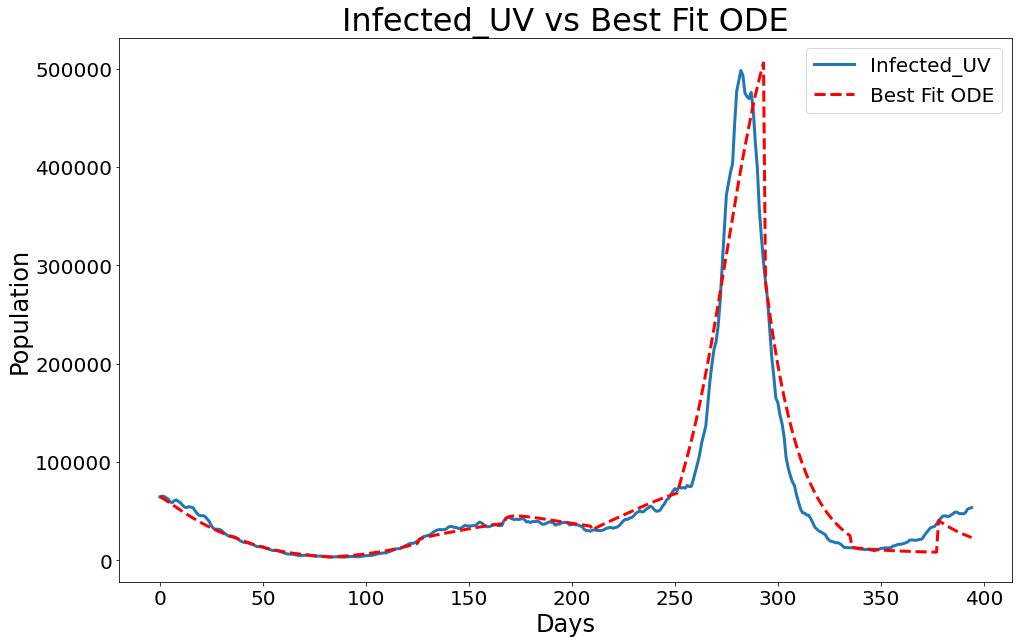

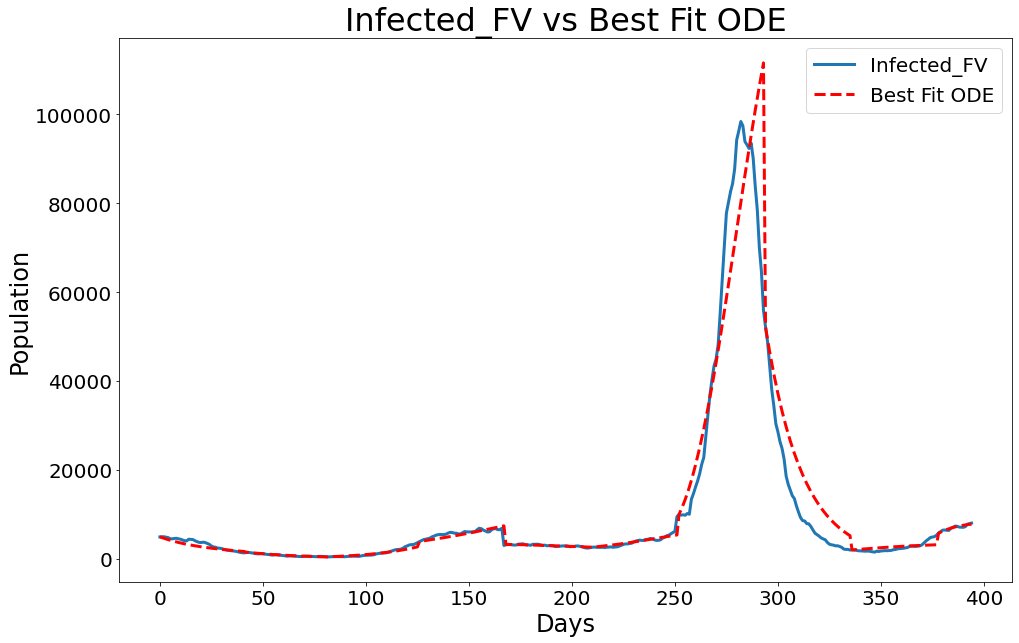

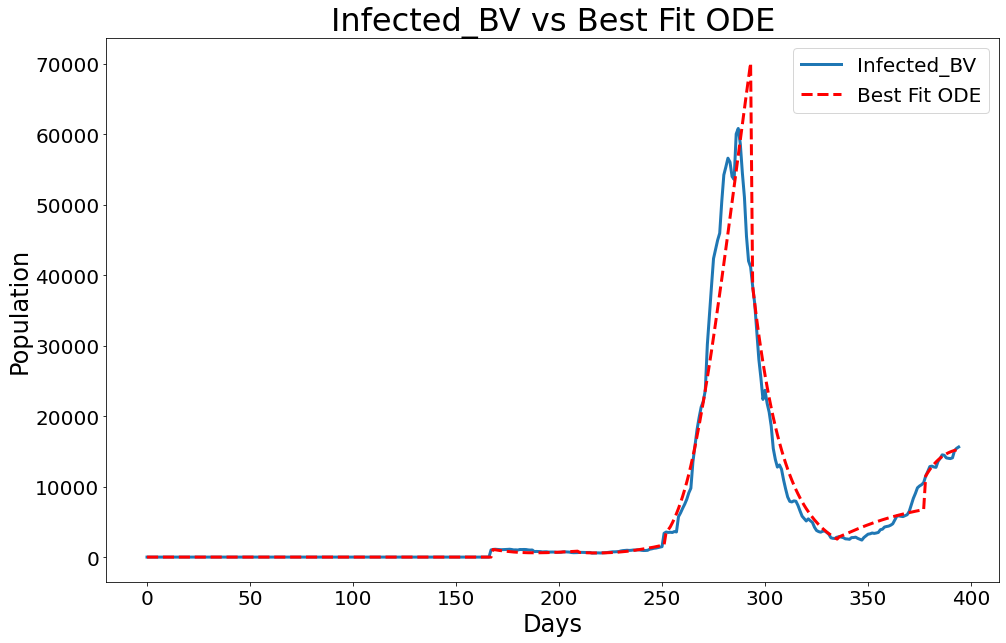

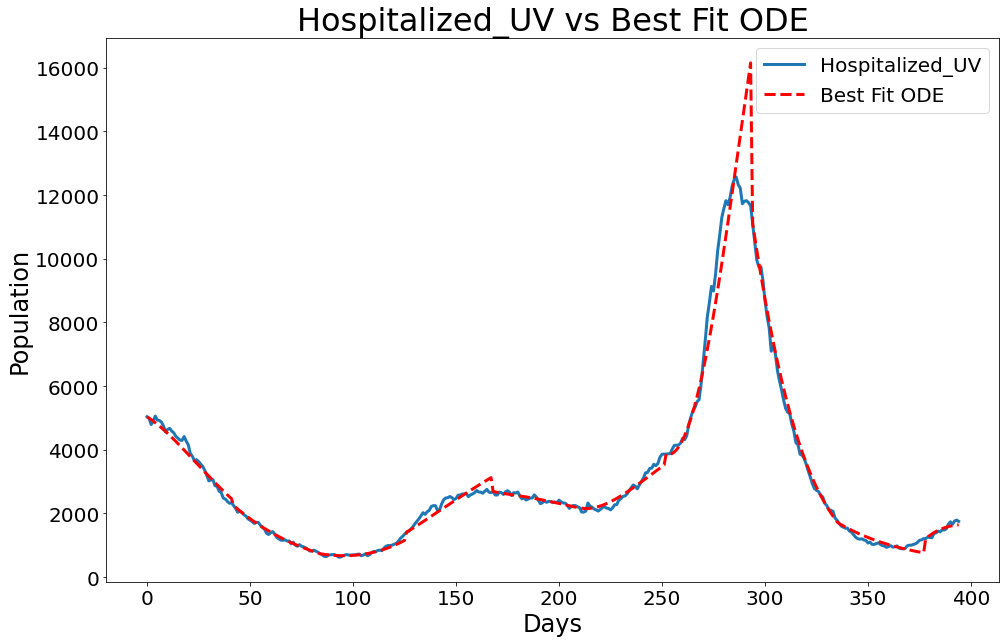

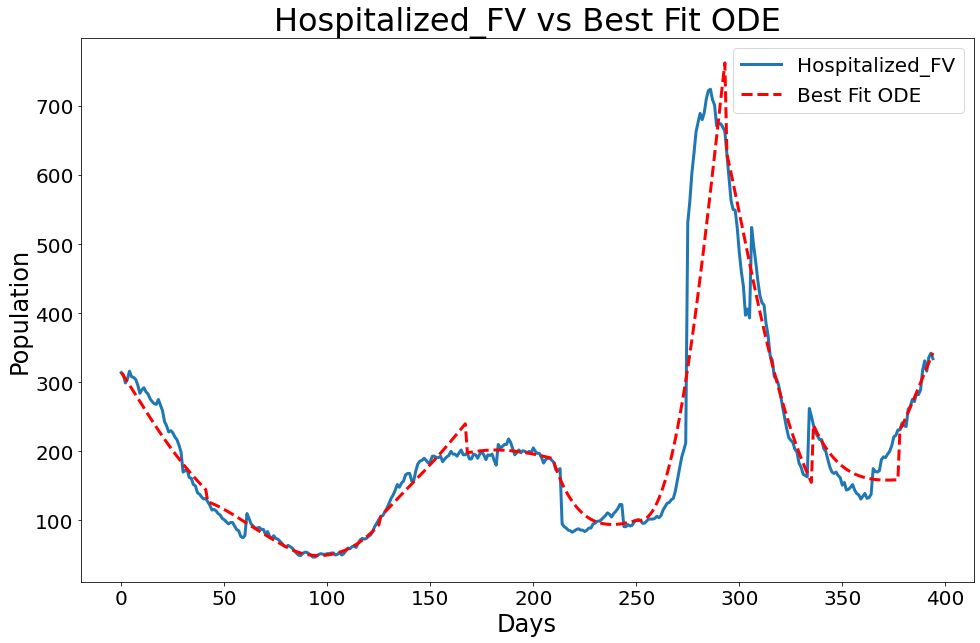

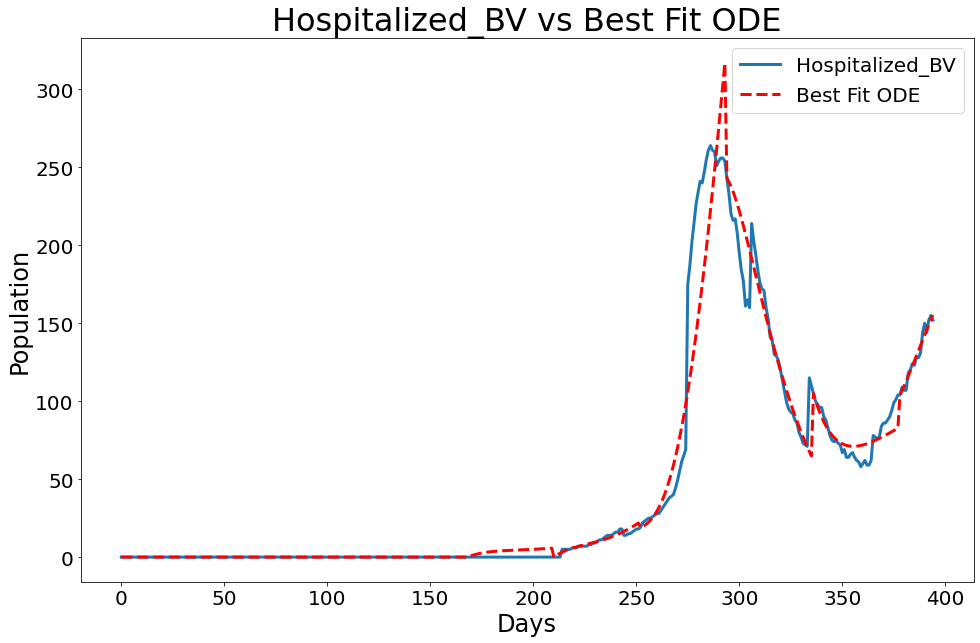

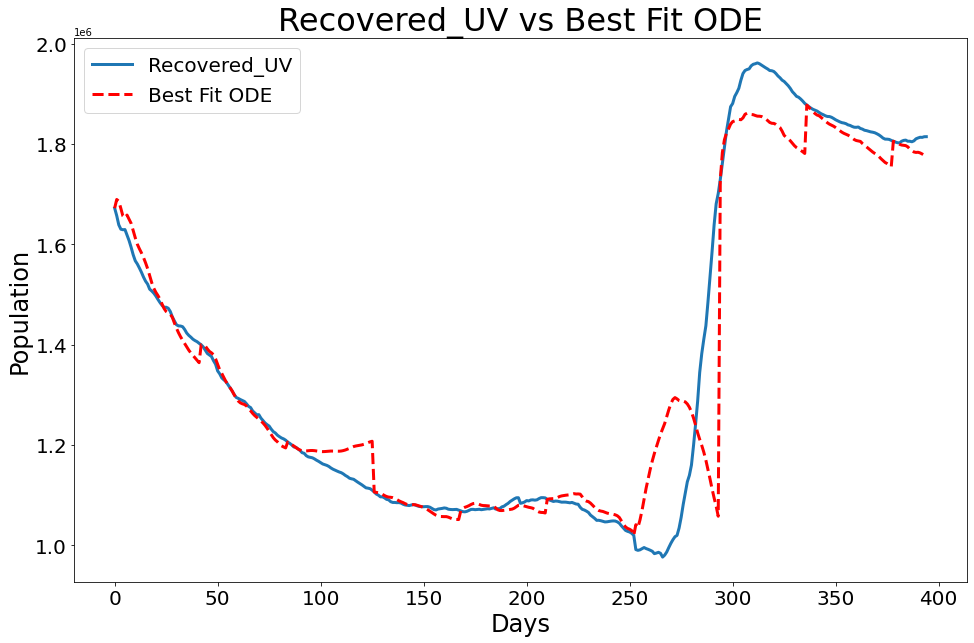

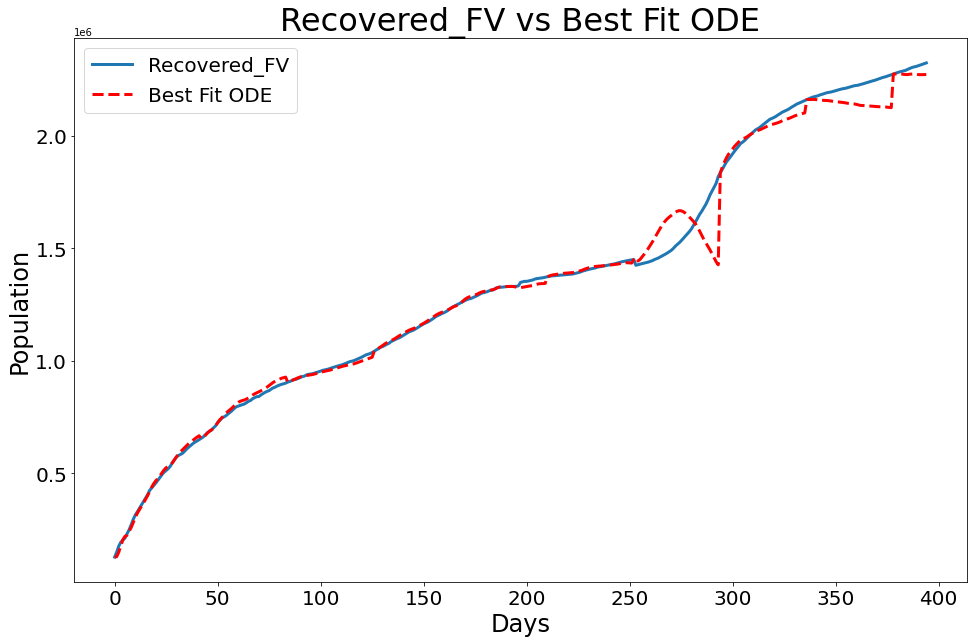

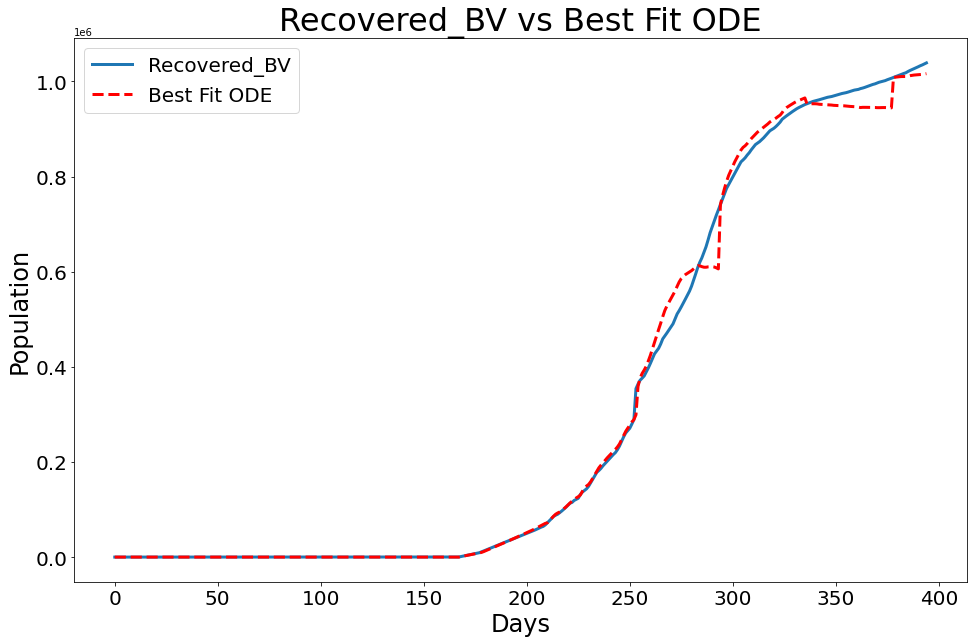

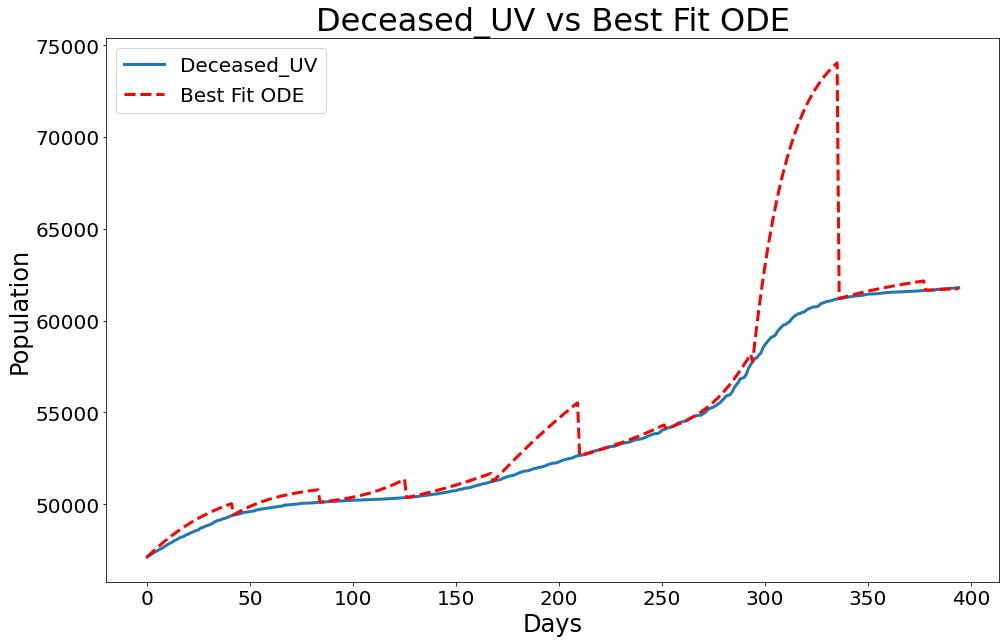

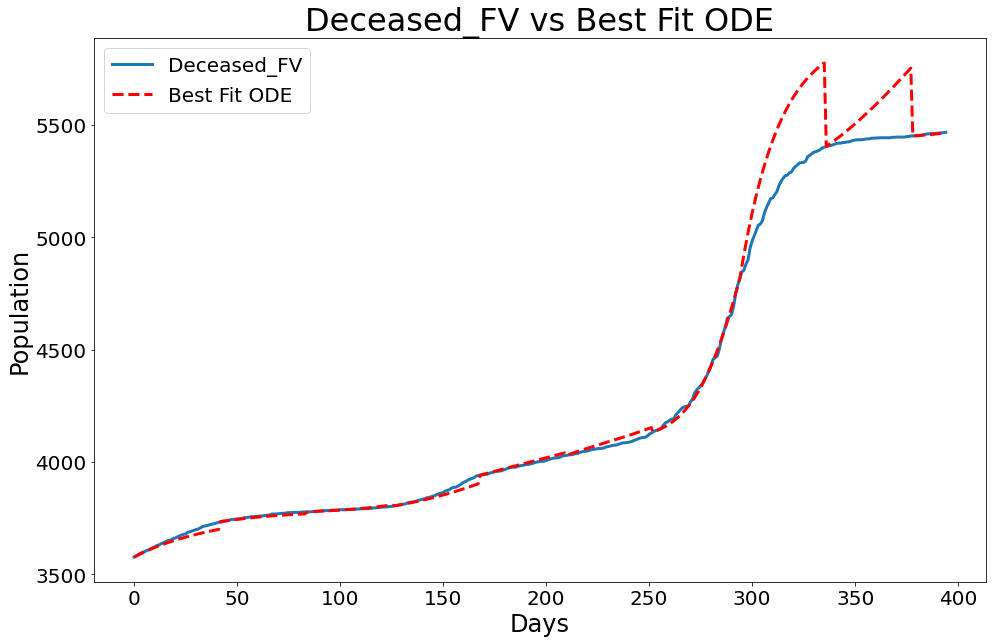

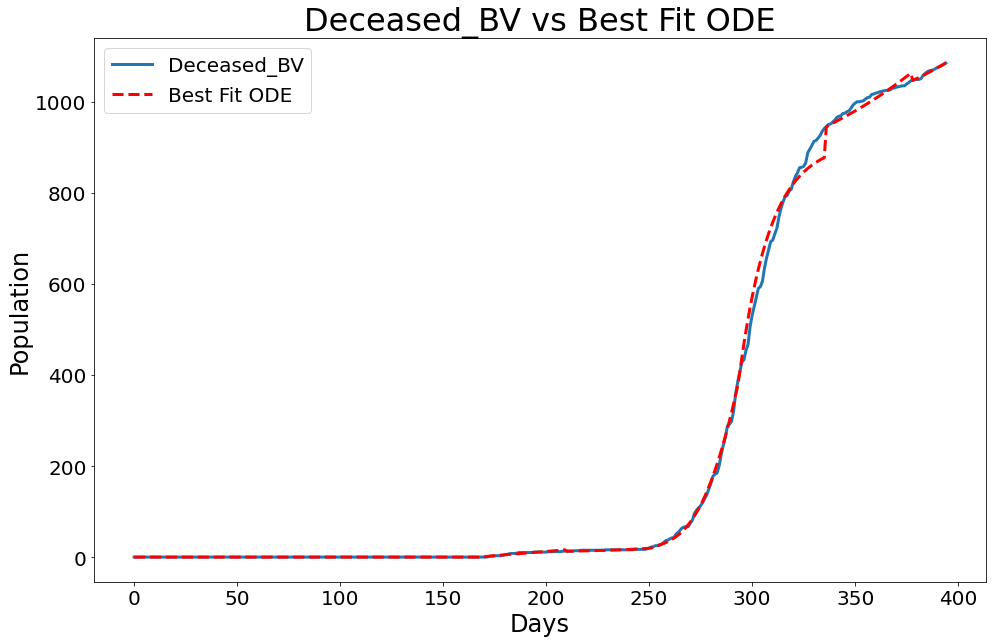

In [54]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 42
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'RK45', 2), method='leastsq', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

In [55]:
import datetime as dt
import matplotlib.dates as mdates

susceptible_actual = data_overall[214:, 0] + data_overall[214:, 1] + data_overall[214:, 2]
susceptible_prediction = model_pred_overall[214:, 0] + model_pred_overall[214:, 1] + model_pred_overall[214:, 2]

exposed_actual = data_overall[214:, 3] + data_overall[214:, 4] + data_overall[214:, 5]
exposed_prediction = model_pred_overall[214:, 3] + model_pred_overall[214:, 4] + model_pred_overall[214:, 5]

infected_actual = data_overall[214:, 6] + data_overall[214:, 7] + data_overall[214:, 8]
infected_prediction = model_pred_overall[214:, 6] + model_pred_overall[214:, 7] + model_pred_overall[214:, 8]

hospitalized_actual = data_overall[214:, 9] + data_overall[214:, 10] + data_overall[214:, 11]
hospitalized_prediction = model_pred_overall[214:, 9] + model_pred_overall[214:, 10] + model_pred_overall[214:, 11]

recovered_actual = data_overall[214:, 12] + data_overall[214:, 13] + data_overall[214:, 14]
recovered_prediction = model_pred_overall[214:, 12] + model_pred_overall[214:, 13] + model_pred_overall[214:, 14]

deceased_actual = data_overall[214:, 15] + data_overall[214:, 16] + data_overall[214:, 17]
deceased_prediction = model_pred_overall[214:, 15] + model_pred_overall[214:, 16] + model_pred_overall[214:, 17]

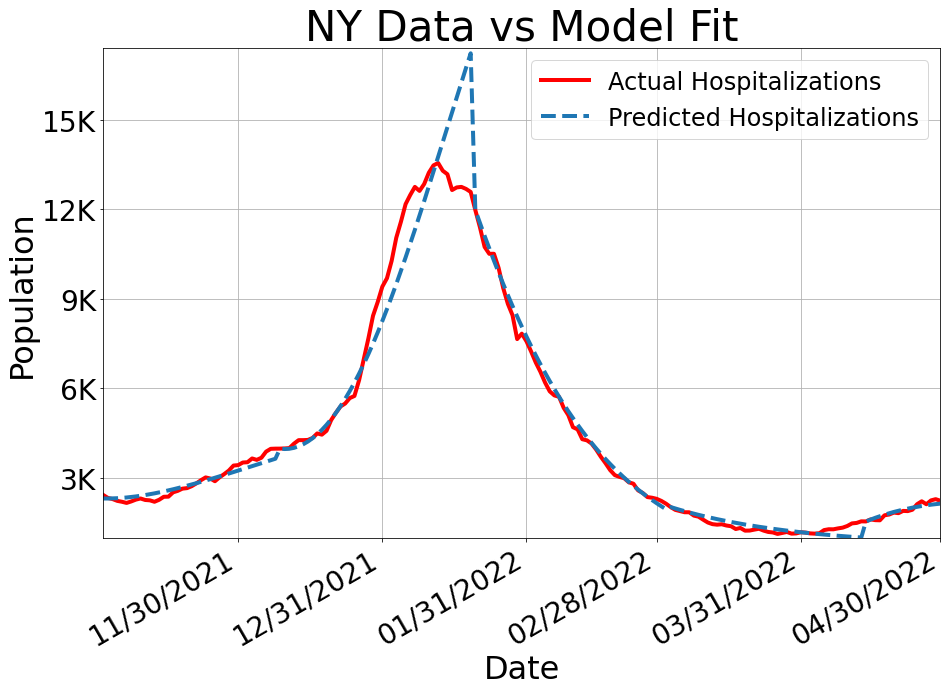

In [67]:
dates = ['11/01/2021', '12/01/2022', '01/01/2022', '02/01/2022', '03/01/2022', '05/01/2022']
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
days = mdates.drange(x[0], x[-1], dt.timedelta(days=1))

test_dates = ['11/30/2021', '12/31/2021', '01/31/2022', '02/28/2022', '03/31/2022', '04/30/2022']
test = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in test_dates]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

normalized_infected_actual = scaler.fit_transform(infected_actual.reshape(-1, 1))
normalized_hospitalized_actual = scaler.fit_transform(hospitalized_actual.reshape(-1, 1))
normalized_deceased_actual = scaler.fit_transform(deceased_actual.reshape(-1, 1))

normalized_infected_prediction = scaler.fit_transform(infected_prediction.reshape(-1, 1))
normalized_hospitalized_prediction = scaler.fit_transform(hospitalized_prediction.reshape(-1, 1))
normalized_deceased_prediction = scaler.fit_transform(deceased_prediction.reshape(-1, 1))

min_value = min(min(hospitalized_actual), min(hospitalized_prediction)) * 0.99

max_value = max(max(hospitalized_actual), max(hospitalized_prediction)) * 1.01
step_size = 3_000
max_value = int(max_value)

# Plots
plt.figure(figsize=(15, 10))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=1, interval=1))

# plt.plot(days, infected_actual, linewidth=2, c='red', label='Actual Active Infections')
# plt.plot(days, infected_prediction, '--', linewidth=2, c='blue', label='Predicted Active Infections')

plt.plot(days, hospitalized_actual, linewidth=4, c='red', label='Actual Hospitalizations')
plt.plot(days, hospitalized_prediction, '--', linewidth=4, label='Predicted Hospitalizations')

# plt.plot(days, deceased_actual, linewidth=2, c='red', label='Actual Hospitalizations')
# plt.plot(days, deceased_prediction, '--', linewidth=2, c='blue', label='Predicted Hospitalizations')

plt.xlabel('Date', fontsize=32)
plt.ylabel('Population', fontsize=32)
plt.title(f'NY Data vs Model Fit', fontsize=42)
plt.xticks([test[0], test[1], test[2], test[3], test[4], test[5]], fontsize=28)
plt.yticks(np.arange(step_size, max_value, step_size),
           [f"{int(i / 1000)}K" for i in range(step_size, max_value, step_size)], fontsize=28)
# plt.yticks(fontsize=20)
plt.legend(fontsize=24)
plt.ylim(ymin=min_value, ymax=max_value)
plt.xlim(xmin=x[0], xmax=test[-1])
plt.grid()
plt.gcf().autofmt_xdate()
plt.savefig('acutal_vs_model_hospitalizations.png')
# plt.show()

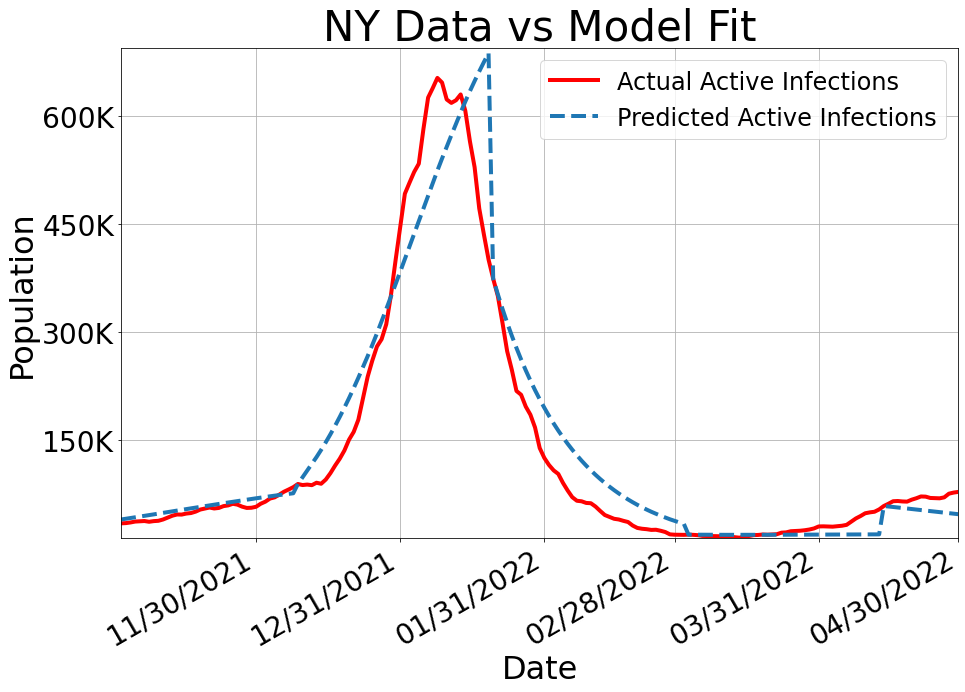

In [68]:
dates = ['11/01/2021', '12/01/2022', '01/01/2022', '02/01/2022', '03/01/2022', '05/01/2022']
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
days = mdates.drange(x[0], x[-1], dt.timedelta(days=1))

test_dates = ['11/30/2021', '12/31/2021', '01/31/2022', '02/28/2022', '03/31/2022', '04/30/2022']
test = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in test_dates]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

normalized_infected_actual = scaler.fit_transform(infected_actual.reshape(-1, 1))
normalized_hospitalized_actual = scaler.fit_transform(hospitalized_actual.reshape(-1, 1))
normalized_deceased_actual = scaler.fit_transform(deceased_actual.reshape(-1, 1))

normalized_infected_prediction = scaler.fit_transform(infected_prediction.reshape(-1, 1))
normalized_hospitalized_prediction = scaler.fit_transform(hospitalized_prediction.reshape(-1, 1))
normalized_deceased_prediction = scaler.fit_transform(deceased_prediction.reshape(-1, 1))

min_value = min(min(infected_actual), min(infected_prediction)) * 0.99

max_value = max(max(infected_actual), max(infected_prediction)) * 1.01
step_size = 150_000
max_value = int(max_value)

# Plots
plt.figure(figsize=(15, 10))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=1, interval=1))

plt.plot(days, infected_actual, linewidth=4, c='red', label='Actual Active Infections')
plt.plot(days, infected_prediction, '--', linewidth=4, label='Predicted Active Infections')

# plt.plot(days, hospitalized_actual, linewidth=2, c='red', label='Actual Hospitalizations')
# plt.plot(days, hospitalized_prediction, '--', linewidth=2, c='blue', label='Predicted Hospitalizations')

# plt.plot(days, deceased_actual, linewidth=2, c='red', label='Actual Hospitalizations')
# plt.plot(days, deceased_prediction, '--', linewidth=2, c='blue', label='Predicted Hospitalizations')

plt.xlabel('Date', fontsize=32)
plt.ylabel('Population', fontsize=32)
plt.title(f'NY Data vs Model Fit', fontsize=42)
plt.xticks([test[0], test[1], test[2], test[3], test[4], test[5]], fontsize=28)
plt.yticks(np.arange(step_size, max_value, step_size),
           [f"{int(i / 1000)}K" for i in range(step_size, max_value, step_size)], fontsize=28)
# plt.yticks(fontsize=20)
plt.legend(fontsize=24)
plt.ylim(ymin=min_value, ymax=max_value)
plt.xlim(xmin=x[0], xmax=test[-1])
plt.grid()
plt.gcf().autofmt_xdate()
plt.savefig('acutal_vs_model_infections.png')
# plt.show()

### DOP853 Leastsq CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'DOP853', 2), method='leastsq', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### Radau Leastsq CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'Radau', 2), method='leastsq', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### BDF Leastsq CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'BDF', 2), method='leastsq', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### LSODA Leastsq CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'LSODA', 2), method='leastsq', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### RK23 lbfgsb CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'RK23', 2), method='lbfgsb', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### RK45 lbfgsb CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'RK45', 2), method='lbfgsb', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### DOP853 lbfgsb CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'DOP853', 2), method='lbfgsb', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### Radau lbfgsb CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'Radau', 2), method='lbfgsb', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### BDF lbfgsb CDC

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'BDF', 2), method='lbfgsb', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### LSODA LBFGSB CDC Initialization Params

In [ ]:
# same as below but pretty print
overall_runtime_start = time()
# Test beta without new cases and unconstrained
# DisProportional Split. Data split into 28 day periods.
compartments = ['Susceptible_UV', 'Susceptible_FV', 'Susceptible_BV', 'Exposed_UV', 'Exposed_FV', 'Exposed_BV',
                'Infected_UV', 'Infected_FV', 'Infected_BV', 'Hospitalized_UV', 'Hospitalized_FV',
                'Hospitalized_BV', 'Recovered_UV', 'Recovered_FV', 'Recovered_BV', 'Deceased_UV', 'Deceased_FV', 'Deceased_BV']

time_frame = 14
number_of_splits = int(np.ceil(395 / time_frame))

model_preds = []
data_values = []
original_residuals = []
total_residual = 0
param_dict = {}

for split_number in range(number_of_splits):
    
    print(f'Split {split_number + 1} of {number_of_splits}:\n')
    
    split_min_index = split_number * time_frame
    split_max_index = min((split_number + 1) * time_frame, 395)

    parameter_computation = ParameterComputation(filepath='./epidemiological_model_data.csv', compartment_names=compartments, data_split_min=split_min_index, data_split_max=split_max_index, constrained_beta=False)

    start = time()
    model_fit_solve_ivp = minimize(
        parameter_computation.residual_solve_ivp, parameter_computation.parameters,
        args=(parameter_computation.t, parameter_computation.epidemiological_compartment_values,
              'LSODA', 2), method='lbfgsb', nan_policy='omit')
    
    print('Runtime:', time() - start, 'seconds')
    
    model_pred = parameter_computation.epidemiological_compartment_values + \
        parameter_computation.original_residual.reshape(parameter_computation.epidemiological_compartment_values.shape)
    
    data = parameter_computation.epidemiological_compartment_values
    
    model_preds.append(model_pred)
    data_values.append(data)
 
    original_residuals.append(parameter_computation.original_residual)
    print('Split Residual:', np.sum(np.abs(parameter_computation.original_residual)))
#     print(f'\n\nModel Fit {split_number}:\n', report_fit(model_fit_solve_ivp))
#     print(model_fit_solve_ivp.params.pretty_print())
    print('-------------------------------')
    for name, param in model_fit_solve_ivp.params.items():
        if name not in param_dict:
            param_dict[f'{name}'] = [param.value]
        else:
            param_dict[f'{name}'].append(param.value)
            
total_residual += np.sum(np.abs(np.asarray(original_residuals[:-1])))
    
print('Total Residual:', total_residual)
print('Overall Runtime:', time() - overall_runtime_start, 'seconds')
for key in param_dict.keys():
    print(f'{key}:', param_dict[key])
model_pred_overall = np.concatenate([model_preds[i] for i in range(len(model_preds))])
data_overall = np.concatenate([data_values[i] for i in range(len(data_values))])

print('\n\n\n\n\n\n')

for i, compartment_name in enumerate(compartments):
    plt.figure(figsize=(16, 10))
    plt.plot(data_overall[:, i], linewidth=3, label=compartment_name)
    plt.plot(model_pred_overall[:, i], '--', linewidth=3, c='red', label='Best Fit ODE')
    plt.xlabel('Days', fontsize=24)
    plt.ylabel('Population', fontsize=24)
    plt.title(f'{compartment_name} vs Best Fit ODE', fontsize=32)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()